In [1]:
# -------------------------- LIBRARIES NECESSARY IN THIS PROJECT  -------------------------- #

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import *
import zipfile
import pylab as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from pydot import graph_from_dot_data
from six import StringIO

from IPython.display import Image

import pydotplus

# -------------------------- FUNCTIONS -------------------------- #

def getDataSet(data_path):
    return pd.read_csv(data_path)

## Upload dataSets

### Members dataset cleasing

In [2]:
# -------------------------- PATH OF THE DATASETS USED IN THE PROJECT  -------------------------- #
zf = zipfile.ZipFile('../dataSets/main.zip')

main_data_set_all_fields = pd.read_csv(zf.open('main.csv'))

## Data manipulation and cleansing

In [3]:
# Check the dataSet fields
main_data_set_all_fields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              32950 non-null  int64  
 1   member_key              32950 non-null  object 
 2   updated_at              32950 non-null  object 
 3   first_name              32950 non-null  object 
 4   last_name               32950 non-null  object 
 5   disabilities            8383 non-null   object 
 6   SA1                     3751 non-null   float64
 7   price_zone_code         32950 non-null  object 
 8   plan_key                32950 non-null  object 
 9   plan_status             32950 non-null  object 
 10  plan_start_date         32950 non-null  object 
 11  plan_end_date           32950 non-null  object 
 12  budget_level3_name      840 non-null    object 
 13  budget_level3_key       840 non-null    object 
 14  budget_level2_key       32950 non-null

In [4]:
main_data_set_all_fields.head(4)

,Unnamed: 0,member_key,updated_at,first_name,last_name,disabilities,SA1,price_zone_code,plan_key,plan_status,...,budget_level1_key,budget_level1_name,invoice_state,claim_state,allocated_amount,requested_amount,funded_amount,allocated_amount_total,requested_amount_total,funded_amount_total
0,0,00109970-7029-11eb-81d6-9d4df94b6224,2021-04,Wynny,Pressman,NaN,NaN,ACT_NSW_QLD_VIC,588427f1-e45d-4a6e-b307-9c68a13849ef,PLAN_DELIVERY_ACTIVE,...,58745466-f597-11e9-bfb4-022d4762bb3c,Core,ALL_PAID,PAID,50000.00,98.8000,98.80,272168.34,11316.7000,11316.70
1,1,00109970-7029-11eb-81d6-9d4df94b6224,2021-04,Wynny,Pressman,NaN,NaN,ACT_NSW_QLD_VIC,588427f1-e45d-4a6e-b307-9c68a13849ef,PLAN_DELIVERY_ACTIVE,...,58745466-f597-11e9-bfb4-022d4762bb3c,Core,ALL_PAID,PAID,222168.34,11217.9000,11217.90,272168.34,11316.7000,11316.70
2,2,0010f240-3b5d-11eb-aa73-7be7bbd3c758,2021-04,Beryl,McDuff,Asperger syndrome,3138648.0,ACT_NSW_QLD_VIC,ef286fe8-8b36-4d77-97a0-59f9ef3df9b8,PLAN_DELIVERY_ACTIVE,...,5874551b-f597-11e9-bfb4-022d4762bb3c,Capacity Building,ALL_PAID,PAID,9801.60,2559.6384,2559.67,9801.60,2559.6384,2559.67
3,3,00117a50-cbc6-11ea-805a-75fc51d39a77,2021-04,Jethro,Perchard,NaN,NaN,ACT_NSW_QLD_VIC,8aa26238-d922-4963-bcaf-427d24a610bc,COMPLETED,...,5874551b-f597-11e9-bfb4-022d4762bb3c,Capacity Building,ALL_PAID,PAID,64524.00,8503.6500,8503.65,64524.00,8503.6500,8503.65


In [5]:
main_data_No_NaN = main_data_set_all_fields.replace(np.nan, 'NA')

main_data_No_NaN = main_data_No_NaN[(main_data_No_NaN["plan_status"] == 'PLAN_DELIVERY_ACTIVE')]

In [6]:
# Select just the fields to be used
main_data_set = main_data_No_NaN.groupby([
                                           "member_key"
                                         , "first_name"
                                         , "last_name"
                                         #, "budget_level1_key"
                                         #, "budget_level1_name"
                                         #, "budget_level2_key"
                                         #, "budget_level2_name"
                                         , "plan_start_date"
                                         , "plan_end_date"
                                         , "allocated_amount_total"
                                        ]).agg({"funded_amount": "sum", "allocated_amount": "sum"}).reset_index().copy()

In [7]:
months_total = main_data_set[{
                              "member_key"
                            , "plan_start_date"
                            , "plan_end_date"}].copy()

months_total['plan_months_total'] = ((pd.to_datetime(months_total['plan_end_date']).dt.year
                                   -  pd.to_datetime(months_total['plan_start_date']).dt.year) * 12) + (pd.to_datetime(months_total['plan_end_date']).dt.month
                                   -  pd.to_datetime(months_total['plan_start_date']).dt.month)

months_total_merged = months_total[{"member_key", "plan_months_total"}]
                            
months_total_merged = months_total[{
                                    "member_key"
                                  , "plan_months_total"
                            }].groupby([
                                       "member_key"
                                     , "plan_months_total"
                                       ]).count().reset_index()

months_total_merged = pd.merge(main_data_set, months_total_merged, how="left", on=["member_key"])

In [8]:
allocated_amount_month = months_total_merged[{
                                              "member_key"
                                            #, "budget_level1_key"
                                            #, "budget_level2_key"
                                            , "plan_months_total"
                                            , "allocated_amount"
                                            }].copy()

allocated_amount_month["allocated_amount_month"] = allocated_amount_month["allocated_amount"] / allocated_amount_month["plan_months_total"]                                                    

allocated_amount_month = allocated_amount_month[{'member_key', 'allocated_amount_month'}]
#allocated_amount_month = allocated_amount_month[{'member_key', 'budget_level1_key', 'budget_level2_key', 'allocated_amount_month'}]


months_total_merged_monthly = pd.merge(months_total_merged, allocated_amount_month, how="left", on=["member_key"])

In [9]:
month_today = main_data_set[{
                           "member_key"
                         #, "budget_level1_key"
                         #, "budget_level2_key"
                         , "plan_start_date"
                            }].copy()


month_today['month_actual'] = ((pd.to_datetime("today").year -  pd.to_datetime(month_today['plan_start_date']).dt.year) * 12)                                                                                                                     + (pd.to_datetime("today").month - pd.to_datetime(month_today['plan_start_date']).dt.month)

#month_today = month_today[{'member_key', 'budget_level1_key', 'budget_level2_key', 'month_actual'}]

month_today = month_today[{'member_key', 'month_actual'}]

# month_actual = pd.merge(months_total_merged_monthly, month_today, how="left", on=["member_key", "budget_level1_key", "budget_level2_key"])

month_actual = pd.merge(months_total_merged_monthly, month_today, how="left", on=["member_key"])

month_actual["spent_amount_predicted"] = month_actual["allocated_amount_month"] * month_actual["month_actual"]

In [10]:
month_actual['funded_amount'] = month_actual['funded_amount'].round(2)
month_actual['allocated_amount'] = month_actual['allocated_amount'].round(2)

month_actual['allocated_amount_month'] = month_actual['allocated_amount_month'].round(2)
month_actual['spent_amount_predicted'] = month_actual['spent_amount_predicted'].round(2)

month_actual['months_left'] = month_actual['plan_months_total'] - month_actual['month_actual']

In [12]:
#month_actual['funded_amount_percentage'] = (month_actual['funded_amount'] / month_actual['allocated_amount']) * 100#).round(2)

#month_actual['months_left_percentage'] = (month_actual['months_left'] / month_actual['plan_months_total']) * 100#).round(2)

#month_actual['funded_amount_months_left'] = month_actual['funded_amount_percentage'] / month_actual['months_left_percentage']#).round(2)

month_actual['funded_amount_percentage'] = (month_actual['funded_amount'] / month_actual['allocated_amount_total']) * 100#).round(2)

month_actual['months_left_percentage'] = (month_actual['months_left'] / month_actual['plan_months_total']) * 100#).round(2)

month_actual['funded_amount_months_left'] = month_actual['funded_amount_percentage'] / month_actual['months_left_percentage']#).round(2)

month_actual = month_actual.loc[
                                (month_actual["plan_months_total"] >= 12)
                              & (month_actual["allocated_amount"] > 0)
                              & (month_actual["months_left"] > 0)
                               ]

# month_actual['spending_status'] = np.where(month_actual['funded_amount_months_left'] < 0.9, 'Overspending', 'Underspending')
# month_actual['spending_status'] = np.where(((month_actual['funded_amount_months_left'] >= 0.9) & (month_actual['funded_amount_months_left'] <= 1.2)), 'On_Track', month_actual['spending_status'])

In [13]:
main_data_set = month_actual[{
                              "member_key"
                            , "first_name" 
                            , "last_name" 
                            #, "budget_level1_key"
                            #, "budget_level1_name"
                            #, "budget_level2_key"
                            #, "budget_level2_name"
                            , "plan_months_total"
                            , "allocated_amount_total"
                            , "funded_amount_months_left"
                            #, "spending_status"
                            }].copy()

In [14]:
 main_data_set['spending_status'] = np.where(main_data_set['funded_amount_months_left'] < 0.9, 'Overspending', 'Underspending')
 main_data_set['spending_status'] = np.where(((main_data_set['funded_amount_months_left'] >= 0.9) & (main_data_set['funded_amount_months_left'] <= 1.2)), 'On_Track', main_data_set['spending_status'])

In [15]:
#month_actual['spending_status'] = np.where(month_actual['funded_amount_months_left'] < 0.9, 'Overspending', 'Underspending')

#month_actual['spending_status'] = np.where(((month_actual['funded_amount_months_left'] >= 0.9) & (month_actual['funded_amount_months_left'] <= 1.2)), 'On_Track', month_actual['spending_status'])

In [16]:
main_data_set = main_data_set[{
                              "member_key"
                            , "first_name" 
                            , "last_name" 
                            #, "budget_level1_key"
                            #, "budget_level1_name"
                            #, "budget_level2_key"
                            #, "budget_level2_name"
                            , "plan_months_total"
                            , "allocated_amount_total"
                            , "spending_status"
                            }].copy()

In [17]:
df_model = main_data_set[{
                          'plan_months_total'
                        , 'allocated_amount_total'
                        , 'spending_status'
                        }].copy()

In [18]:
df_model.head()

,spending_status,plan_months_total,allocated_amount_total
0,Overspending,36,272168.34
1,Overspending,12,9801.60
2,Overspending,36,312025.20
3,Overspending,12,155148.97
4,Overspending,24,320856.89


In [19]:
x = df_model[{
                'plan_months_total'
              , 'allocated_amount_total'
            }]

y = df_model['spending_status']

normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
x = normalized_range.fit_transform(x)

In [20]:
# TRAINING MODEL
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [21]:
feature_cols = ['Plan length', 'Plan amount']

class_names = ['Overspending', 'Underspending', 'On_Track']

In [22]:
model = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [23]:
prediction_score = model.score(x_test, y_test)

print('Prediction score: ', prediction_score * 100)

Prediction score:  86.27726952850105


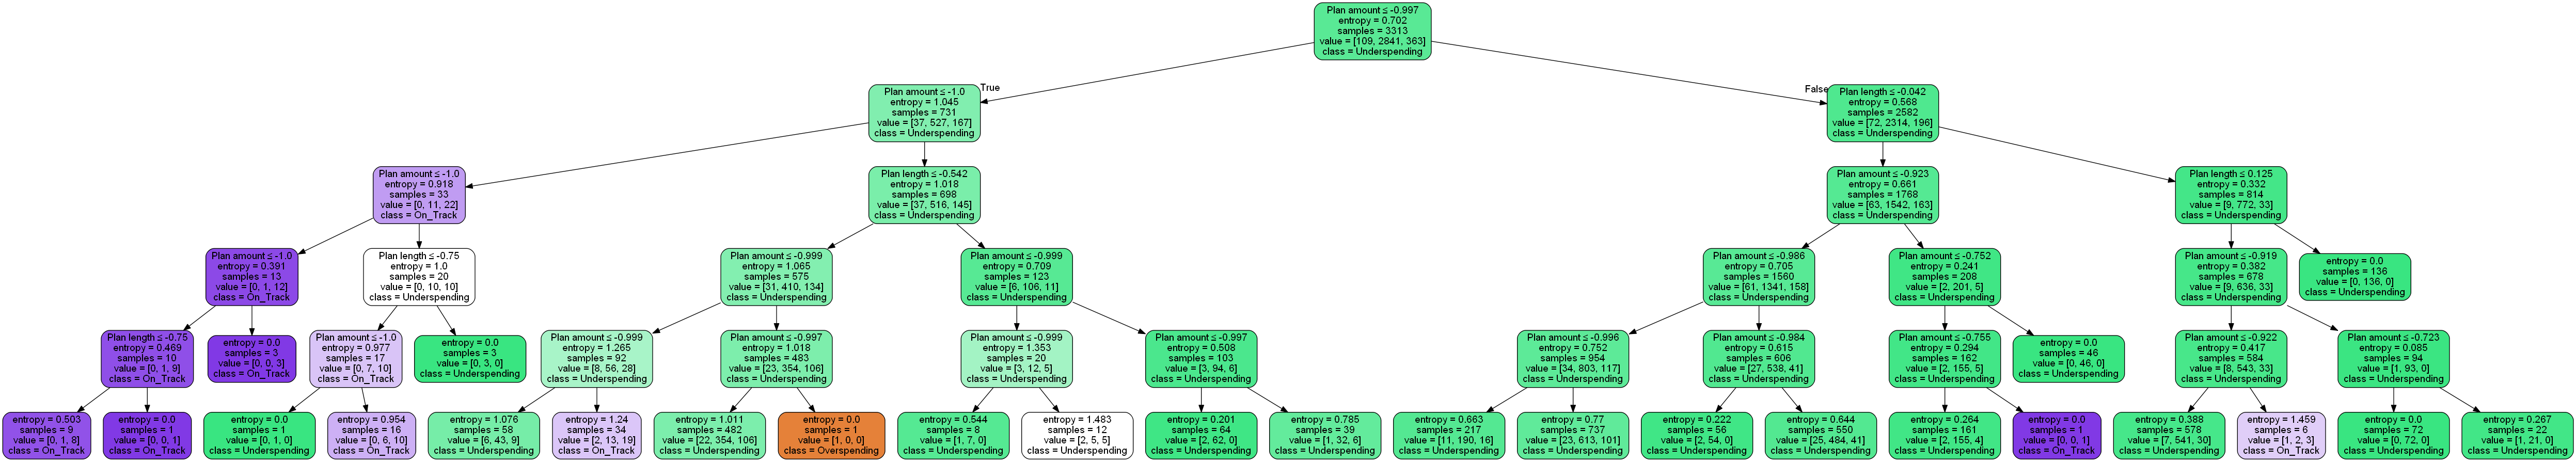

In [24]:
dot_data = StringIO()

tree.export_graphviz(model
              , out_file = dot_data
              , filled = True
              , rounded = True
              , special_characters = True
              , feature_names = feature_cols
              , class_names = class_names
                    )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

graph.write_png('prediction.png')

Image(graph.create_png())

In [25]:
confmtrx = np.array(confusion_matrix(y_test, y_pred))

pd.DataFrame(confmtrx, index=['Overspending','Underspending','On_Track'],
columns=['predicted_Overspending', 'predicted_Underspending', 'predicted_On_Track'])

,predicted_Overspending,predicted_Underspending,predicted_On_Track
Overspending,0,53,0
Underspending,0,1210,24
On_Track,0,118,16


In [26]:
model_to_be_predicted = main_data_set[{
                                       'member_key'
                                     , 'first_name'
                                     , 'last_name'
                                     #, 'budget_level1_key'
                                     #, 'budget_level1_name'
                                     #, 'budget_level2_key'
                                     #, 'budget_level2_name'
                                     , 'plan_months_total'
                                     , 'allocated_amount_total'
                                     , 'spending_status'
                                    }].copy()

In [27]:
df_prediction = pd.DataFrame(columns = [
                                        'member_key'
                                      , 'first_name'
                                      , 'last_name'
                                      #, 'budget_level1_key'
                                      #, 'budget_level1_name'
                                      #, 'budget_level2_key'
                                      #, 'budget_level2_name'
                                      , 'prediction'
                                      ])

for index in range(len(model_to_be_predicted)):
    plan_months_total = model_to_be_predicted['plan_months_total'].iloc[index]
    allocated_amount_total = model_to_be_predicted['allocated_amount_total'].iloc[index]
    
    spending_status = model_to_be_predicted['spending_status'].iloc[index]

    test = model.predict((np.array([plan_months_total, allocated_amount_total]) .reshape(1, -1)))

    if test.astype(str) == 'Overspending':  
        status = 'Overspending'
    else:
        if test.astype(str) == 'Underspending':
            status = 'Underspending'
        else:
            status = 'On_Track'

    df = pd.DataFrame([ [
                         model_to_be_predicted['member_key'].iloc[index]
                       , model_to_be_predicted['first_name'].iloc[index]
                       , model_to_be_predicted['last_name'].iloc[index]
                       #, model_to_be_predicted['budget_level1_key'].iloc[index]
                       #, model_to_be_predicted['budget_level1_name'].iloc[index]
                       #, model_to_be_predicted['budget_level2_key'].iloc[index]
                       #, model_to_be_predicted['budget_level2_name'].iloc[index]
                       , status
                       ] ], columns=list(['member_key'
                                        , 'first_name'
                                        , 'last_name'
                                        #, 'budget_level1_key'
                                        #, 'budget_level1_name'
                                        #, 'budget_level2_key'
                                        #, 'budget_level2_name'
                                        , 'prediction']))


    df_prediction = df_prediction.append(df)

In [28]:
df_prediction.loc[df_prediction['prediction'] == 'Overspending']

,member_key,first_name,last_name,prediction
0,00109970-7029-11eb-81d6-9d4df94b6224,Wynny,Pressman,Overspending
0,0010f240-3b5d-11eb-aa73-7be7bbd3c758,Beryl,McDuff,Overspending
0,0011ebe0-7722-11eb-9ade-8f3368e47951,Eamon,Gammage,Overspending
0,007c1090-d6ca-11ea-bb8a-a73bf14c75f9,Janean,Potzold,Overspending
0,0092d9f0-cbb3-11ea-a1e4-8bc6be8edc1a,Cindelyn,Hebborn,Overspending
...,...,...,...,...
0,ff3eee60-861d-11eb-8428-b1c10f264af2,Florrie,Heningham,Overspending
0,ff630c80-d094-11ea-847f-196f66acbe45,Mureil,Labb,Overspending
0,ff656e00-7fce-11eb-8e57-d94003868067,Jeramie,Burgot,Overspending
0,ffddfbc0-0861-11eb-92a0-2d24c44fa781,Allard,Postle,Overspending


In [29]:
df_prediction.loc[df_prediction['prediction'] == 'Underspending']

,member_key,first_name,last_name,prediction


In [30]:
df_prediction.loc[df_prediction['prediction'] == 'On_Tack']

,member_key,first_name,last_name,prediction


In [31]:
#compression_opts = dict(method='zip',
#                        archive_name='prediction.csv')

#df_prediction.to_csv('../dataSets/prediction.zip', compression=compression_opts)